In [352]:
import numpy as np
import matplotlib.pyplot as plt

In [353]:
var = 0.1
a = 0
b = 1
K = 8
N = 100

In [354]:
def phi(X, K):
    N = len(X)
    V = np.zeros((N, K))
    for i in range(K):
        V[:,i] = X**i
    return V

In [355]:
def ell(theta, K, X, Y):
    return 0.5 * (np.linalg.norm(phi(X, K)@theta - Y)**2)

def grad_ell(theta, K, X, Y):
    return phi(X, K).T @ (((phi(X, K))@theta) - Y)

In [356]:
def ell_map(lam):
    return lambda theta, K, X, Y: 0.5 * ((np.linalg.norm(phi(X, K)@theta - Y)**2) + (lam/2) * np.linalg.norm(theta)**2)

def grad_ell_map(lam):
    return lambda theta, K, X, Y: phi(X, K).T @ ((phi(X, K) @ theta) - Y) + 2 * lam * theta

In [357]:
def x_split(X, Y, N_train):
    N = len(X)

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[test_idx]
    Ytest = Y[test_idx]

    return Xtrain, Xtest, Ytrain, Ytest

In [358]:
def theta_calc_eq(phi_X, Y):
    first_fact = np.linalg.inv((phi_X.T @ phi_X))
    second_fact = phi_X.T @ Y

    theta_found_normeq = first_fact @ second_fact
    return theta_found_normeq

In [359]:
def theta_calc_eq_map(phi_X, Y, lam, K):
    first_fact = np.linalg.inv(phi_X.T @ phi_X + (lam * np.eye(K)))
    second_fact = phi_X.T @ Y
    return first_fact @ second_fact

In [360]:
def GD(t0, D, K, tolf=1e-6, tolx=1e-6, kmax=1000, alpha=1e-2, f=ell, grad_f=grad_ell):
    (X, Y) = D

    tk = t0
    f_vals = [f(tk, K, X, Y)]
    grad_vals = [grad_f(tk, K, X, Y)]
    err_vals = [np.linalg.norm(grad_f(tk, K, X, Y))]
    t_vals = [tk]
    iteration = 0

    while iteration < kmax:
        t_prec = tk

        tk = t_prec - (alpha*grad_f(t_prec, K, X, Y))

        t_vals.append(tk)
        f_vals.append(f(tk, K, X, Y))
        grad_vals.append(grad_f(tk, K, X, Y))       
        err_vals.append(np.linalg.norm(grad_f(tk, K, X, Y)))

        iteration+=1

        if np.linalg.norm(grad_f(tk, K, X, Y)) < tolf:
            break

        if np.linalg.norm(tk - t_prec, 2) < tolx:
            break

    return tk

In [361]:
def SGD(t0, D, K, batch_size = 10, n_epochs = 30, alpha=1e-5, l=ell, grad_l=grad_ell):
    (X, Y) = D
    N = len(X)
    
    X_backup = X
    Y_backup = Y


    n_batch_per_epoch = N // batch_size
    t_vals = [t0]
    f_vals = [l(t0, K, X, Y)]
    grad_f_vals = [grad_l(t0, K, X, Y)]
    err_vals = [np.linalg.norm(grad_l(t0, K, X, Y))]

    for epoch in range(n_epochs):
        idx = np.arange(N)
        np.random.shuffle(idx)

        for k in range(n_batch_per_epoch):
            batch_indices = idx[k * batch_size : (k + 1) * batch_size]

            Mx = X[batch_indices]
            My = Y[batch_indices]

            t = t_vals[-1] - alpha * grad_l(t_vals[-1], K, Mx, My)
            t_vals.append(t)

        
        X = X_backup
        Y = Y_backup
        f_vals.append(l(t, K, X, Y))
        grad_f_vals.append(grad_l(t, K, X, Y))
        err_vals.append(np.linalg.norm(grad_l(t, K, X, Y)))

    return t_vals[-1]
    

In [362]:
def create_set(K=K, N=N, a=a, b=b):    
    X = np.linspace(a, b, N)
    theta_true = np.ones(K).T

    e = np.random.normal(0, var, N)

    Y = phi(X, K) @ theta_true + e

    N_train = int(N/3*2)
    X_train, X_test, Y_train, Y_test = x_split(X, Y, N_train)

    return X_train, X_test, Y_train, Y_test

In [363]:
X_train, X_test, Y_train, Y_test = create_set()
D = (X_train, Y_train)

In [364]:
def MLE(K, theta_calc, D):

    (X, Y) = D
    theta_found = None

    if theta_calc == "NE":
        theta_found = theta_calc_eq(phi(X, K), Y)
    elif theta_calc == "GD":
        theta_zero_1 = np.zeros((K,))
        theta_found = GD(theta_zero_1, D, K)
    elif theta_calc == "SGD":
        theta_zero_1 = np.random.normal(1, var, K)
        theta_found = SGD(theta_zero_1, D, K)

    return theta_found
    

In [365]:
def MAP(K, theta_calc, D, lam = 1):

    (X, Y) = D
    theta_found = None

    if theta_calc == "NE":
        theta_found = theta_calc_eq_map(phi(X, K), Y, lam, K)
    elif theta_calc == "GD":
        theta_zero_1 = np.zeros((K,))
        theta_found = GD(theta_zero_1, D, K, f=ell_map(lam), grad_f=grad_ell_map(lam))
    elif theta_calc == "SGD":
        theta_zero_1 = np.random.normal(1, var, K)
        theta_found = SGD(theta_zero_1, D, K, l=ell_map(lam), grad_l = grad_ell_map(lam))

    return theta_found
    

In [366]:
k0 = 2
k1 = 3
k2 = 4
k3 = 5
k4 = 6

theta_neq_0 = MLE(k0, "NE", D)
theta_neq_1 = MLE(k1, "NE", D)
theta_neq_2 = MLE(k2, "NE", D)
theta_neq_3 = MLE(k3, "NE", D)
theta_neq_4 = MLE(k4, "NE", D)

In [367]:
def fixed_f(X, K, theta_found):
    return phi(X, K)@theta_found 

def avg_abs_err(theta_found, K, set):
    X, Y = set
    return ((np.linalg.norm(fixed_f(X, K, theta_found) - Y)**2) / len(X))

In [368]:
train_set = (X_train, Y_train)

test_set = (X_test, Y_test)

print("Average absolute error for K=" + str(k1) + ": " + str(avg_abs_err(theta_neq_1, k1, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k2) + ": " + str(avg_abs_err(theta_neq_2, k2, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k3) + ": " + str(avg_abs_err(theta_neq_3, k3, train_set)) + " on train set.")

print("Average absolute error for K=" + str(k1) + ": " + str(avg_abs_err(theta_neq_1, k1, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k2) + ": " + str(avg_abs_err(theta_neq_2, k2, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k3) + ": " + str(avg_abs_err(theta_neq_3, k3, test_set)) + " on test set.")

Average absolute error for K=3: 0.08262892224885938 on train set.
Average absolute error for K=4: 0.012658298708041806 on train set.
Average absolute error for K=5: 0.00878343676462011 on train set.
Average absolute error for K=3: 0.058471136635997956 on test set.
Average absolute error for K=4: 0.014232111625829514 on test set.
Average absolute error for K=5: 0.008992456445904672 on test set.


In [369]:
def plot_for_K(theta, K, method, a=a, b=b, var=var, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test):
    fig, ax = plt.subplots(1, figsize = (10, 8))

    x_to_plot = np.linspace(a, b, 1000)
    y_to_plot = fixed_f(x_to_plot, K, theta)
    ax.plot(x_to_plot, y_to_plot, label="learnt model")

    ax.scatter(X_train, Y_train, label="train dps")
    ax.scatter(X_test, Y_test, label="test dps")


 
    plt.title("Regression model for K="+str(K)+" with " + method)
    plt.legend(loc="upper left")
    plt.show()

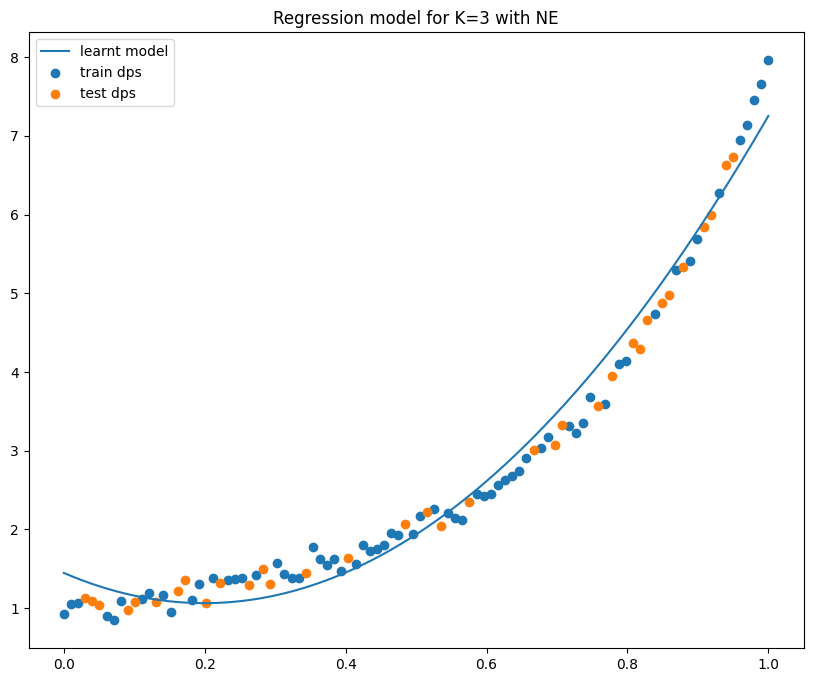

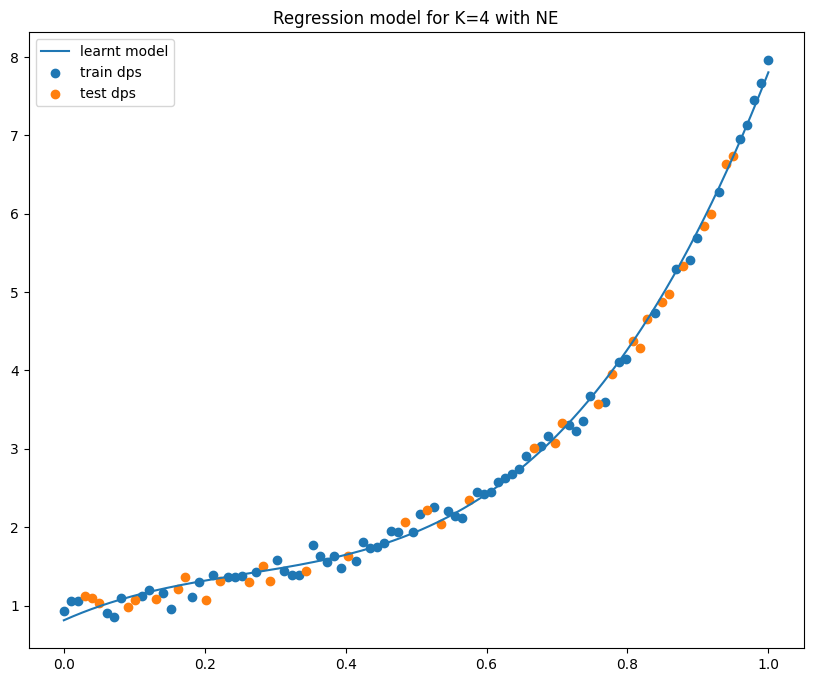

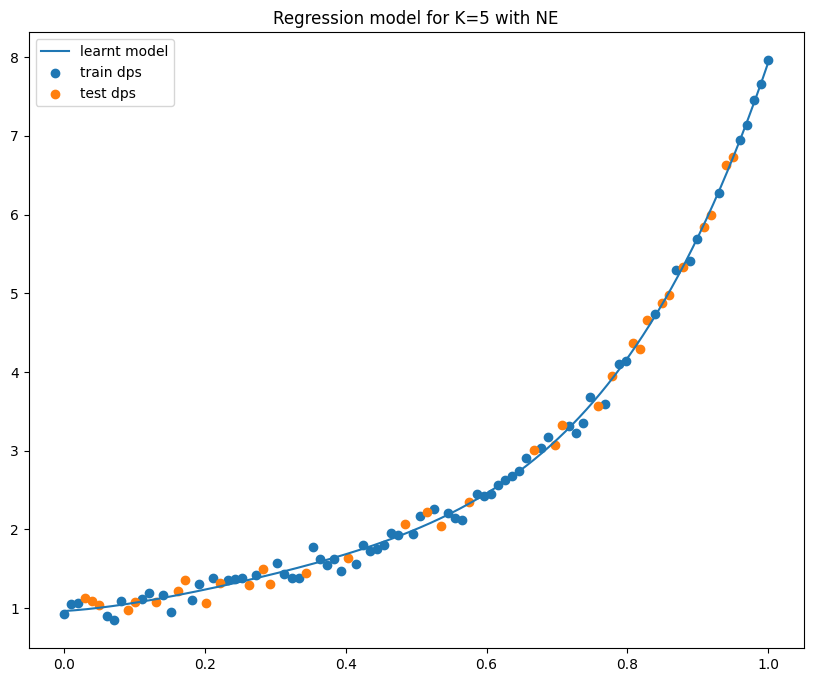

In [370]:
plot_for_K(theta_neq_1, k1, "NE")
plot_for_K(theta_neq_2, k2, "NE")
plot_for_K(theta_neq_3, k3, "NE")

In [371]:
k1_gd = 3
k2_gd = 8
k3_gd = 12

theta_gd_1= MLE(k1_gd, "GD", D)
theta_gd_2= MLE(k2_gd, "GD", D)
theta_gd_3= MLE(k3_gd, "GD", D)

In [372]:
print("Average absolute error for K=" + str(k1_gd) + ": " + str(avg_abs_err(theta_gd_1, k1_gd, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k2_gd) + ": " + str(avg_abs_err(theta_gd_2, k2_gd, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k3_gd) + ": " + str(avg_abs_err(theta_gd_3, k3_gd, train_set)) + " on train set.")

print("Average absolute error for K=" + str(k1_gd) + ": " + str(avg_abs_err(theta_gd_1, k1_gd, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k2_gd) + ": " + str(avg_abs_err(theta_gd_2, k2_gd, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k3_gd) + ": " + str(avg_abs_err(theta_gd_3, k3_gd, test_set)) + " on test set.")

Average absolute error for K=3: 0.08786434084441293 on train set.
Average absolute error for K=8: 0.00892110128351699 on train set.
Average absolute error for K=12: 0.00908198525434263 on train set.
Average absolute error for K=3: 0.05768519523821923 on test set.
Average absolute error for K=8: 0.008694034357514103 on test set.
Average absolute error for K=12: 0.00878907301119132 on test set.


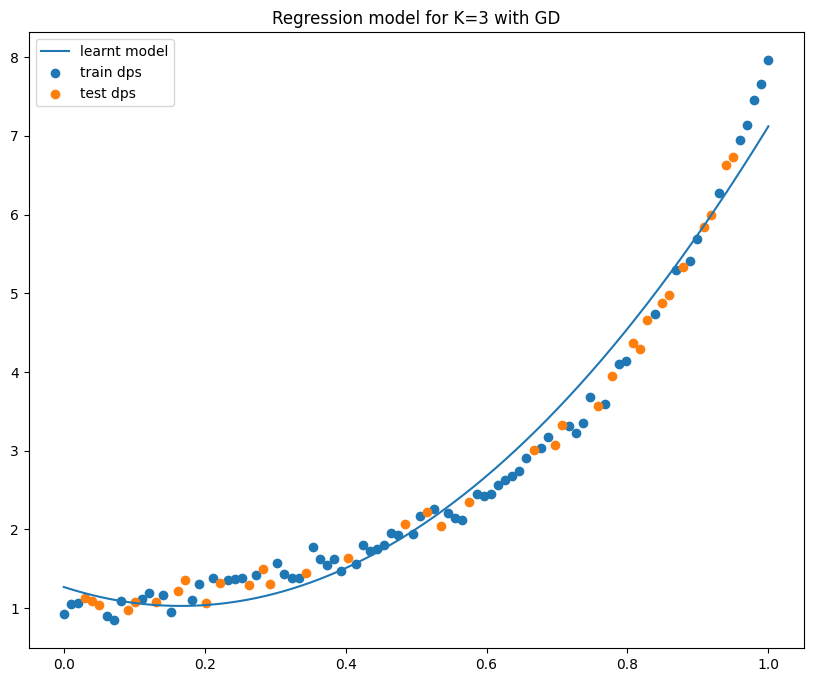

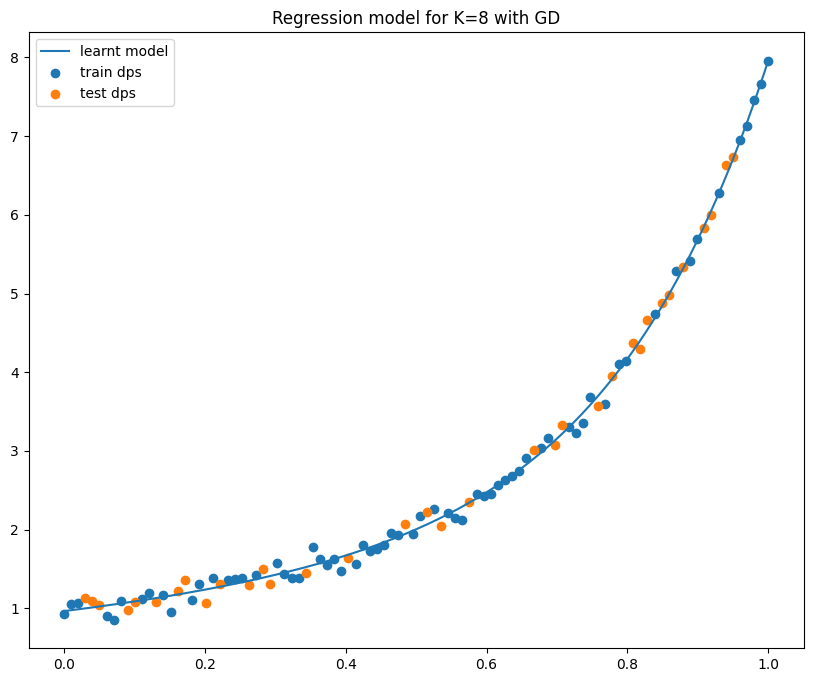

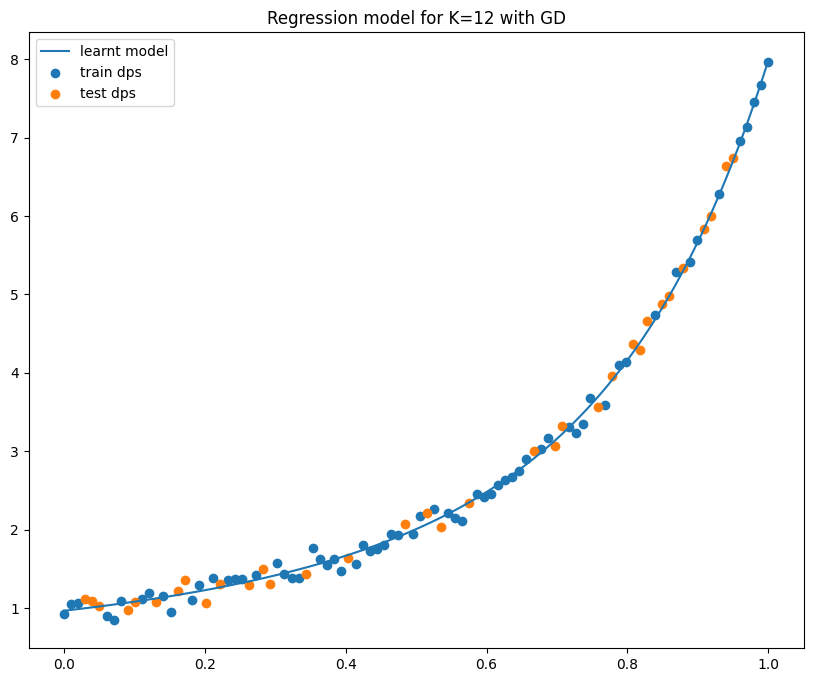

In [373]:
plot_for_K(theta_gd_1, k1_gd, "GD")
plot_for_K(theta_gd_2, k2_gd, "GD")
plot_for_K(theta_gd_3, k3_gd, "GD")

In [374]:
k1_sgd = 3
k2_sgd = 8
k3_sgd = 12

theta_sgd_1= MLE(k1_sgd, "SGD", D)
theta_sgd_2= MLE(k2_sgd, "SGD", D)
theta_sgd_3= MLE(k3_sgd, "SGD", D)

In [375]:
print("Average absolute error for K=" + str(k1_sgd) + ": " + str(avg_abs_err(theta_sgd_1, k1_sgd, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k2_sgd) + ": " + str(avg_abs_err(theta_sgd_2, k2_sgd, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k3_sgd) + ": " + str(avg_abs_err(theta_sgd_3, k3_sgd, train_set)) + " on train set.")

print("Average absolute error for K=" + str(k1_sgd) + ": " + str(avg_abs_err(theta_sgd_1, k1_sgd, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k2_sgd) + ": " + str(avg_abs_err(theta_sgd_2, k2_sgd, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k3_sgd) + ": " + str(avg_abs_err(theta_sgd_3, k3_sgd, test_set)) + " on test set.")

Average absolute error for K=3: 2.0129108659937116 on train set.
Average absolute error for K=8: 0.08059989856947877 on train set.
Average absolute error for K=12: 0.789699877988602 on train set.
Average absolute error for K=3: 2.058594385226022 on test set.
Average absolute error for K=8: 0.07551261325313442 on test set.
Average absolute error for K=12: 0.40994040234171825 on test set.


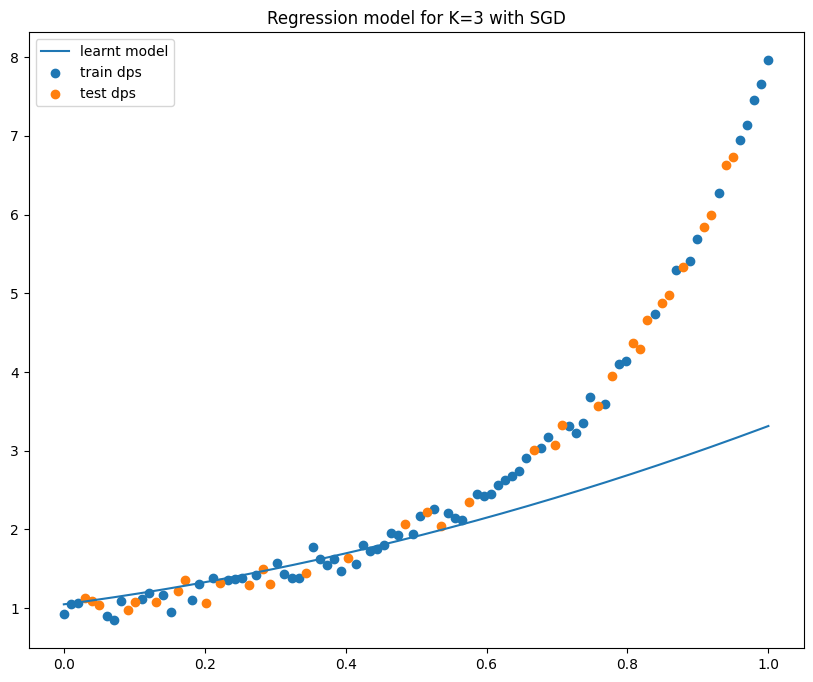

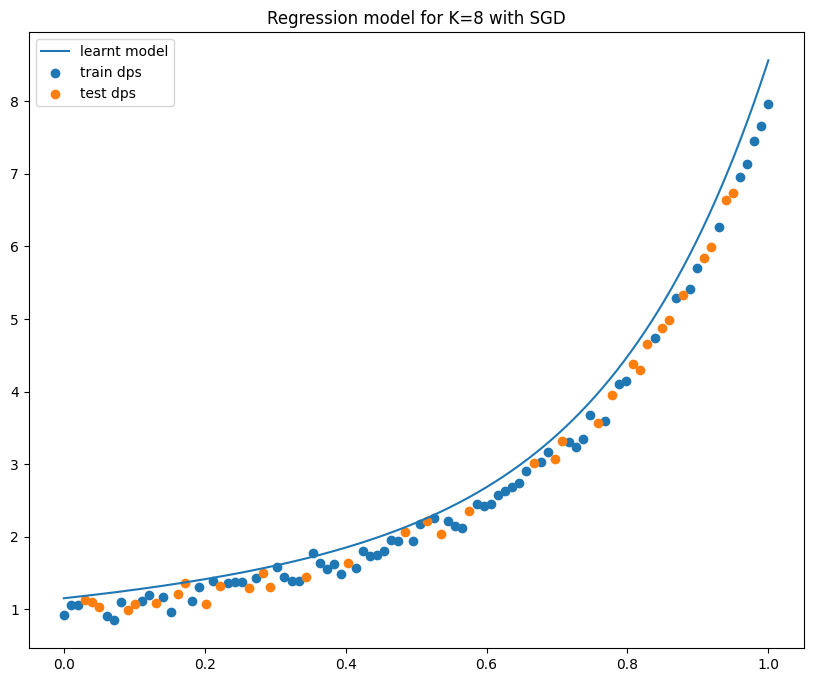

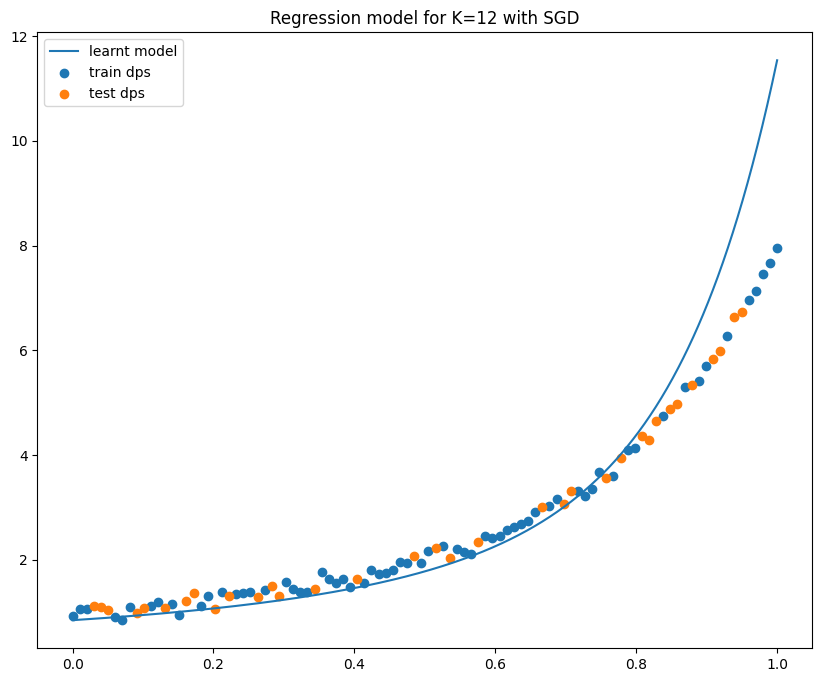

In [376]:
plot_for_K(theta_sgd_1, k1_sgd, "SGD")
plot_for_K(theta_sgd_2, k2_sgd, "SGD")
plot_for_K(theta_sgd_3, k3_sgd, "SGD")

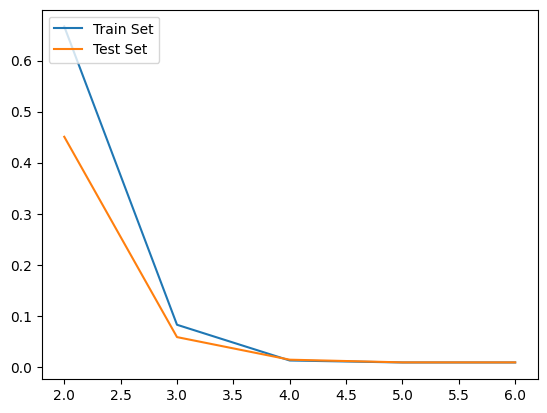

In [377]:
ks_0 = [k0, k1, k2, k3, k4]

err_0_0 = avg_abs_err(theta_neq_0, k0, train_set)
err_0_1 = avg_abs_err(theta_neq_1, k1, train_set)
err_0_2 = avg_abs_err(theta_neq_2, k2, train_set)
err_0_3 = avg_abs_err(theta_neq_3, k3, train_set)
err_0_4 = avg_abs_err(theta_neq_4, k4, train_set)
errs_0 = [err_0_0, err_0_1, err_0_2, err_0_3, err_0_4]

err_1_0 = avg_abs_err(theta_neq_0, k0, test_set)
err_1_1 = avg_abs_err(theta_neq_1, k1, test_set)
err_1_2 = avg_abs_err(theta_neq_2, k2, test_set)
err_1_3 = avg_abs_err(theta_neq_3, k3, test_set)
err_1_4 = avg_abs_err(theta_neq_4, k4, test_set)

errs_1 = [err_1_0, err_1_1, err_1_2, err_1_3, err_1_4]

plt.plot(ks_0, errs_0, label="Train Set")
plt.plot(ks_0, errs_1, label="Test Set")
plt.legend(loc="upper left")
plt.show()

In [378]:
k1 = 3
k2 = 8
k3 = 12
ks = [k1, k2, k3]
lams = [1, 3, 5]

theta_neq_1 = MAP(k1, "NE", D, lam=lams[0])
theta_neq_2 = MAP(k2, "NE", D, lam=lams[0])
theta_neq_3 = MAP(k3, "NE", D, lam=lams[0])

thetas_1 = [theta_neq_1, theta_neq_2, theta_neq_3]

theta_gd_4 = MAP(k1, "GD", D, lam=lams[1])
theta_gd_5 = MAP(k2, "GD", D, lam=lams[1])
theta_gd_6 = MAP(k3, "GD", D, lam=lams[1])

thetas_2 = [theta_gd_4, theta_gd_5, theta_gd_6]

theta_sgd_7 = MAP(k1, "SGD", D, lam=lams[2])
theta_sgd_8 = MAP(k2, "SGD", D, lam=lams[2])
theta_sgd_9 = MAP(k3, "SGD", D, lam=lams[2])

thetas_3 = [theta_sgd_7, theta_sgd_8, theta_sgd_9]

In [379]:
print("Average absolute error for K=" + str(k1) + ": " + str(avg_abs_err(theta_neq_1, k1, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k2) + ": " + str(avg_abs_err(theta_neq_2, k2, train_set)) + " on train set.")
print("Average absolute error for K=" + str(k3) + ": " + str(avg_abs_err(theta_neq_3, k3, train_set)) + " on train set.")

print("Average absolute error for K=" + str(k1) + ": " + str(avg_abs_err(theta_neq_1, k1, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k2) + ": " + str(avg_abs_err(theta_neq_2, k2, test_set)) + " on test set.")
print("Average absolute error for K=" + str(k3) + ": " + str(avg_abs_err(theta_neq_3, k3, test_set)) + " on test set.")

Average absolute error for K=3: 0.2936374123752365 on train set.
Average absolute error for K=8: 0.01128193895489419 on train set.
Average absolute error for K=12: 0.01260742829363688 on train set.
Average absolute error for K=3: 0.16964271730579766 on test set.
Average absolute error for K=8: 0.011494741512496173 on test set.
Average absolute error for K=12: 0.018198122925055498 on test set.


In [380]:
def plot_for_K_lam(thetas, Ks, lam, method, a=a, b=b, var=var, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test):
    
    fig, ax = plt.subplots(1,len(Ks), figsize = (20, 5))
    plt.suptitle("Lambda = " + str(lam) + " with " + method)
    for i, K in enumerate(Ks):
        x_to_plot = np.linspace(a, b, 2000)
        y_to_plot = fixed_f(x_to_plot, K, thetas[i])
        ax[i].plot(x_to_plot, y_to_plot, label="learnt model")

        ax[i].scatter(X_train, Y_train, label="train dps")
        ax[i].scatter(X_test, Y_test, label="test dps")


    
        ax[i].set_title("K="+str(K))
        ax[i].legend(loc="upper left")
    plt.show()


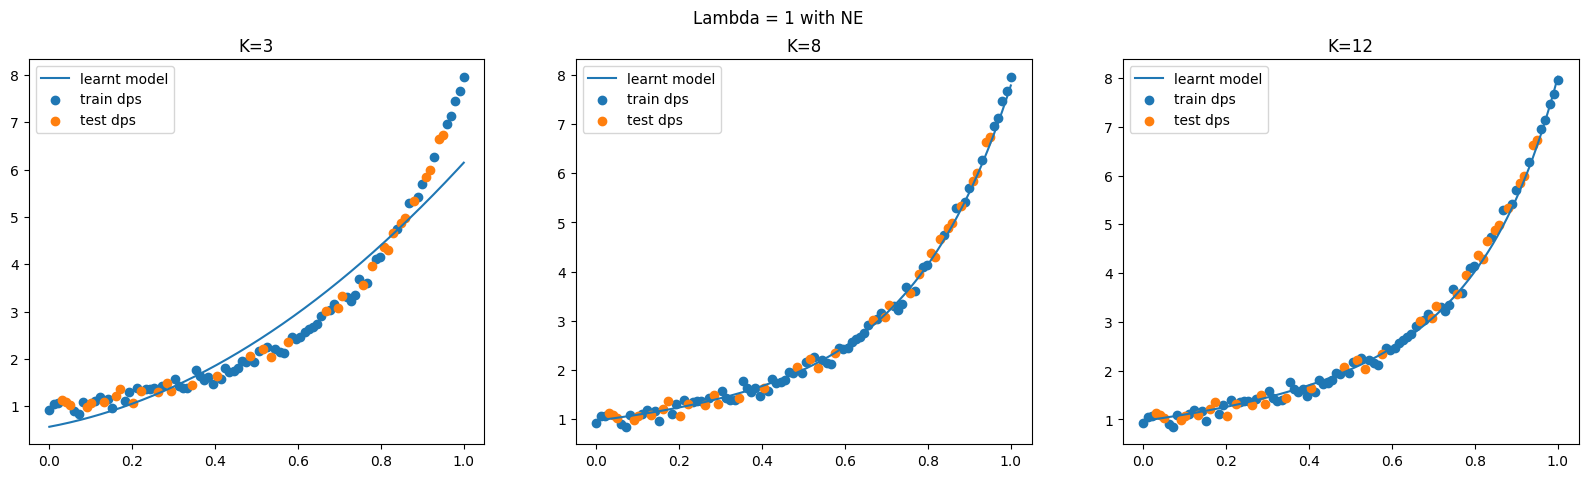

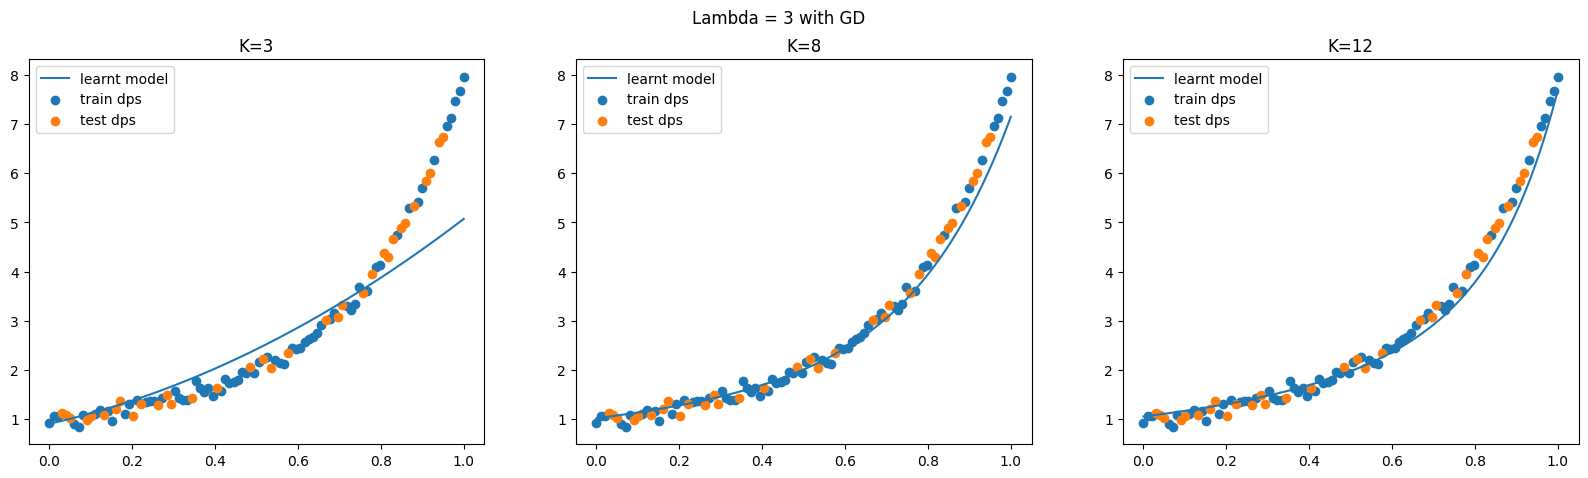

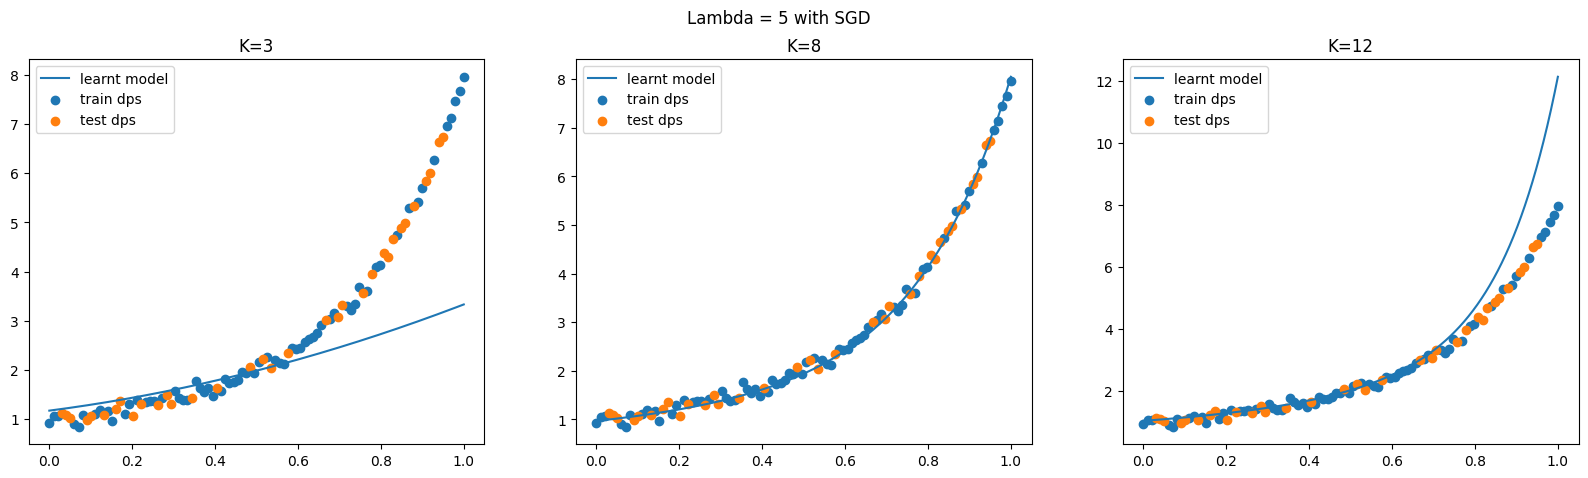

In [381]:
plot_for_K_lam(thetas_1, ks, lams[0], "NE")
plot_for_K_lam(thetas_2, ks, lams[1], "GD")
plot_for_K_lam(thetas_3, ks, lams[2], "SGD")